# Import packages & install packages

In [25]:
!pip install --upgrade

DEPRECATION: Loading egg at c:\users\sywis\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages\gym-0.26.2-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\sywis\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages\gym_notices-0.0.8-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\sywis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERRO

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from weather_pca import PCA
import datetime

# Load Dataset

https://www.kaggle.com/datasets/arunjangir245/airline-flight-dataset-schedule-performance-etc/data 

In [27]:
current_directory = os.getcwd()
weather_data_path = os.path.join(current_directory, "weather_data.csv")
data  = pd.read_csv(weather_data_path)  

# Convert Date_Time to datetime format
data['Date_Time'] = pd.to_datetime(data['Date_Time'], format='%Y-%m-%d %H:%M:%S')

# Convert datetime to Unix timestamps
data['Unix_Timestamp'] = data['Date_Time'].apply(lambda x: int(x.timestamp()))
print(data.head())

       Location           Date_Time  Temperature_C  Humidity_pct  \
0     San Diego 2024-01-14 21:12:46      10.683001     41.195754   
1     San Diego 2024-05-17 15:22:10       8.734140     58.319107   
2     San Diego 2024-05-11 09:30:59      11.632436     38.820175   
3  Philadelphia 2024-02-26 17:32:39      -8.628976     54.074474   
4   San Antonio 2024-04-29 13:23:51      39.808213     72.899908   

   Precipitation_mm  Wind_Speed_kmh  Unix_Timestamp  
0          4.020119        8.233540      1705266766  
1          9.111623       27.715161      1715959330  
2          4.607511       28.732951      1715419859  
3          3.183720       26.367303      1708968759  
4          9.598282       29.898622      1714397031  


# PCA Reduction

## Using HW3 PCA Code

Cleaning & Filtering data

In [28]:
## Weather
# Filter data for Houston location
df = data[data['Location'] == 'Houston']

# Select numeric columns for PCA
numeric_columns = ["Temperature_C", "Humidity_pct", "Precipitation_mm", "Wind_Speed_kmh"]

# Explicitly use .loc to fill missing values in numeric columns
for col in numeric_columns:
    df.loc[:, col] = df[col].fillna(df[col].median())  
    
# Drop the original columns
df = df.drop(columns=['Location', 'Date_Time'])

#* Remove rows with missing target
df = df.dropna()



Spliting up data

In [29]:
#* Define features and target
y = df['Unix_Timestamp']
X = df.drop('Unix_Timestamp', axis=1)

#* Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Begin PCA

In [34]:
# Initialize PCA
pca = PCA()

X_train_np = X_train.astype(float).to_numpy()
X_test_np = X_test.astype(float).to_numpy()

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit PCA on the scaled data
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled, K=3)
X_test_pca = pca.transform(X_test_scaled, K=3)

print(f"X train pca shape: {X_train_pca.shape}")
print(f"X test pca shape: {X_test_pca.shape}")
print(f"Y train pca shape: {y_train.shape}")

X train pca shape: (80060, 3)
X test pca shape: (20016, 3)
Y train pca shape: (80060,)


Get Sample size

In [31]:
# Reset the index of y_train to ensure alignment
y_train = y_train.reset_index(drop=True)

# Randomly choose indices
sample_size = min(5000, len(y_train))  # Ensure sample size does not exceed available data
indices = np.random.choice(len(y_train), size=sample_size, replace=False)

# Subset the data
X_sample = X_train_pca[indices]
y_sample = y_train.iloc[indices]  # Use .iloc to access rows by position

print("Sampled X shape:", X_sample.shape)
print("Sampled y shape:", y_sample.shape)


Sampled X shape: (5000, 3)
Sampled y shape: (5000,)


Plotting

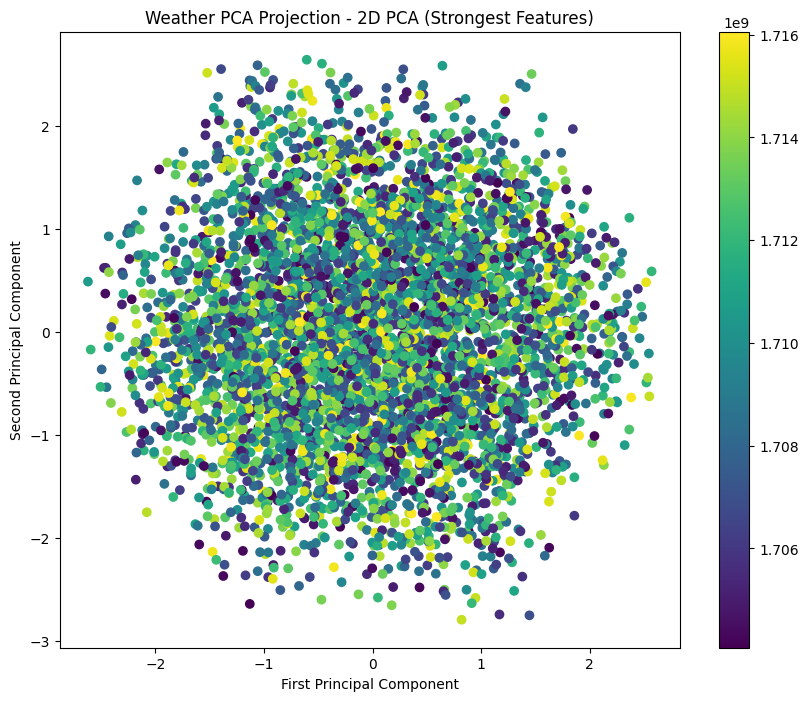

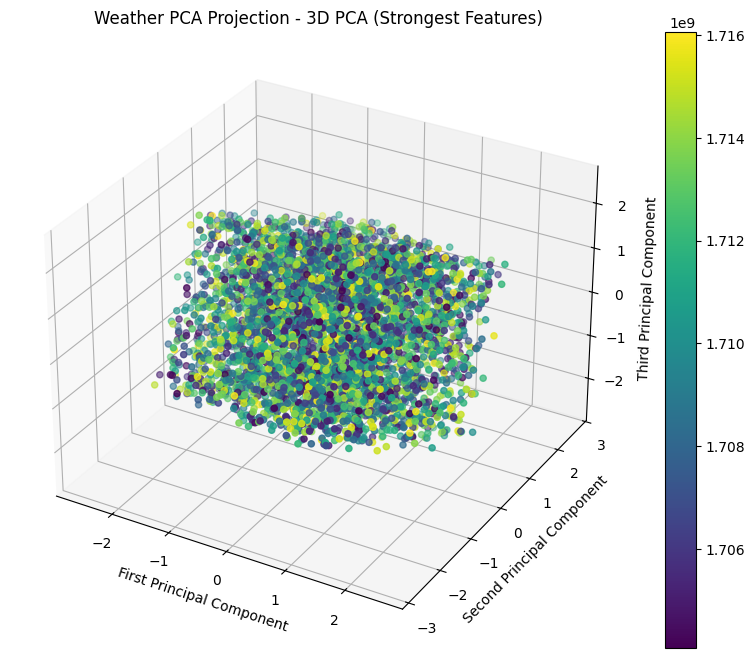

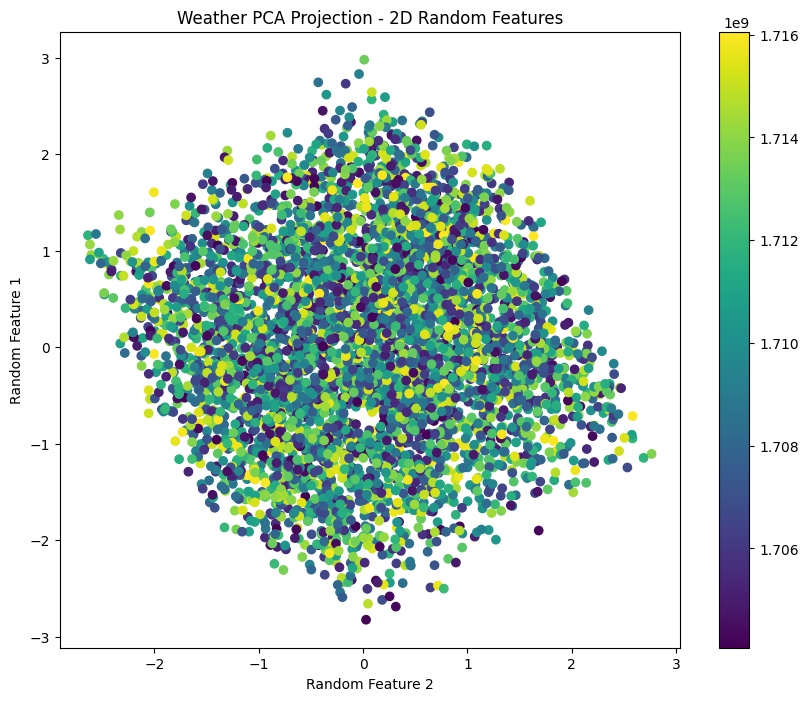

In [32]:
# pca.check_plot(X_sample, y_sample)
pca.visualize(X=X_sample, y=y_sample, fig_title="Weather PCA Projection")